In [2]:
import geopandas as gpd
import pandas as pd
import geopandas
import shapely.geometry as geom
from polygon_geohasher.polygon_geohasher import polygon_to_geohashes, geohashes_to_polygon
import pygeohash as gh
%matplotlib inline
import geohash
import geopandas as gp
import pandas as pd
import math
import geojson
from geojson import MultiLineString
from shapely.geometry import MultiLineString
from shapely.geometry import MultiPoint
import numpy as np
from shapely import geometry
from shapely.geometry import Point, Polygon, box,LineString
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry.polygon import LinearRing, Polygon
from numpy import cos,sin,arccos
import numpy as np
from pylab import *
from shapely.ops import cascaded_union
from shapely.geometry import Point, LineString, mapping
import scipy.interpolate
import geopy
import geopy.distance
import time
import networkx as nx
from sklearn.model_selection import train_test_split
import datetime as dt

In [135]:
weekend_busy_G = nx.Graph()
weekend_busy = pd.read_csv('weekend_geohash_busy.csv')
weekend_busy = weekend_busy.groupby('node_trip').max().reset_index()
weekend_busy[['source', 'dest']] = weekend_busy.node_trip.str.split("-", expand=True)
for line in weekend_busy.iterrows():
    weekend_busy_G.add_edge(line[1]['source'], line[1]['dest'], weight=line[1]['time_taken'])
    
    

In [136]:
weekend_normal_G = nx.Graph()
weekend_normal = pd.read_csv('weekend_geohash_normal.csv')
weekend_normal = weekend_normal.groupby('node_trip').max().reset_index()
weekend_normal[['source', 'dest']] = weekend_normal.node_trip.str.split("-", expand=True)
for line in weekend_normal.iterrows():
    weekend_normal_G.add_edge(line[1]['source'], line[1]['dest'], weight=line[1]['time_taken'])

In [137]:
weekday_busy_G = nx.Graph()
weekday_busy = pd.read_csv('weekday_geohash_busy.csv')
weekday_busy = weekday_busy.groupby('node_trip').max().reset_index()
weekday_busy[['source', 'dest']] = weekday_busy.node_trip.str.split("-", expand=True)
for line in weekday_busy.iterrows():
    weekday_busy_G.add_edge(line[1]['source'], line[1]['dest'], weight=line[1]['time_taken'])

In [138]:
weekday_normal_G = nx.Graph()
weekday_normal = pd.read_csv('weekday_geohash_normal.csv')
weekday_normal = weekday_normal.groupby('node_trip').max().reset_index()
weekday_normal[['source', 'dest']] = weekday_normal.node_trip.str.split("-", expand=True)
for line in weekday_normal.iterrows():
    weekday_normal_G.add_edge(line[1]['source'], line[1]['dest'], weight=line[1]['time_taken'])

In [139]:
main_graph_G = nx.Graph()
main_df = pd.concat([weekend_busy, weekend_normal, weekday_busy, weekday_normal])
main_df = main_df.groupby('node_trip').max().reset_index()
main_df[['source', 'dest']] = main_df.node_trip.str.split("-", expand=True)
for line in main_df.iterrows():
    main_graph_G.add_edge(line[1]['source'], line[1]['dest'], weight=line[1]['time_taken'])

In [140]:
## Simple testing
test = pd.read_csv('test_set.csv')

# Comment the following lines if not using 6
#test['geohash_source'] = test['geohash_source'].astype(str).str[:6]
#test['geohash_dest'] = test['geohash_dest'].astype(str).str[:6]
test.tail(5)

,trj_id,source_lat,source_lng,source_timestamp,dest_lat,dest_lng,dest_timestamp,time_taken,geohash_source,geohash_dest,hour,day
4195,9843,1.311328,103.844514,2019-04-08 05:32:20,1.421571,103.796251,2019-04-08 05:46:10,830.0,w21z7n9,w23b1fy,5,0
4196,9856,1.375002,103.877892,2019-04-14 00:49:40,1.299927,103.801498,2019-04-14 01:08:33,1133.0,w21zgf3,w21z6h9,0,6
4197,988,1.435788,103.802898,2019-04-14 05:10:53,1.327159,103.827138,2019-04-14 05:29:32,1119.0,w23b4j6,w21zd9s,5,6
4198,9922,1.339792,103.695191,2019-04-18 10:42:31,1.298305,103.853856,2019-04-18 11:40:25,3474.0,w21xxeu,w21z7k2,10,3
4199,9930,1.346563,103.742625,2019-04-19 09:02:31,1.340791,103.981419,2019-04-19 09:30:54,1703.0,w21z8tp,w21zwhh,9,4


In [141]:
len(unique(test['trj_id']))

4200

In [142]:
test['time_taken'].mean()

1246.4185714285713

In [143]:
busy_hours = [8, 9, 10, 17, 18, 19]
weekend_num = [5, 6]
accuracy_arr = []
for test_case in test.iterrows():
    temp_arr = []
    try:
        if test_case[1]['hour'] in busy_hours and test_case[1]['day'] in weekend_num:
            path = nx.dijkstra_path(weekend_busy_G,source=test_case[1]['geohash_source'], target=test_case[1]['geohash_dest'], weight='weight')
            total_weight = 0
            for i in range(len(path) - 1):
                total_weight += weekend_busy_G[path[i]][path[i+1]]['weight']
            temp_arr.append(test_case[1]['trj_id'])
            temp_arr.append(test_case[1]['time_taken'])
            temp_arr.append(total_weight)
            accuracy_arr.append(temp_arr)
        elif test_case[1]['hour'] not in busy_hours and test_case[1]['day'] in weekend_num:
            path = nx.dijkstra_path(weekend_normal_G,source=test_case[1]['geohash_source'], target=test_case[1]['geohash_dest'], weight='weight')
            total_weight = 0
            for i in range(len(path) - 1):
                total_weight += weekend_normal_G[path[i]][path[i+1]]['weight']
            temp_arr.append(test_case[1]['trj_id'])
            temp_arr.append(test_case[1]['time_taken'])
            temp_arr.append(total_weight)
            accuracy_arr.append(temp_arr)
        elif test_case[1]['hour'] in busy_hours and test_case[1]['day'] not in weekend_num:
            path = nx.dijkstra_path(weekday_busy_G,source=test_case[1]['geohash_source'], target=test_case[1]['geohash_dest'], weight='weight')
            total_weight = 0
            for i in range(len(path) - 1):
                total_weight += weekday_busy_G[path[i]][path[i+1]]['weight']
            temp_arr.append(test_case[1]['trj_id'])
            temp_arr.append(test_case[1]['time_taken'])
            temp_arr.append(total_weight)
            accuracy_arr.append(temp_arr)
        elif test_case[1]['hour'] not in busy_hours and test_case[1]['day'] not in weekend_num:
            path = nx.dijkstra_path(weekday_normal_G,source=test_case[1]['geohash_source'], target=test_case[1]['geohash_dest'], weight='weight')
            total_weight = 0
            for i in range(len(path) - 1):
                total_weight += weekday_normal_G[path[i]][path[i+1]]['weight']
            temp_arr.append(test_case[1]['trj_id'])
            temp_arr.append(test_case[1]['time_taken'])
            temp_arr.append(total_weight)
            accuracy_arr.append(temp_arr)
    except:
        try:
            path = nx.dijkstra_path(main_graph_G,source=test_case[1]['geohash_source'], target=test_case[1]['geohash_dest'], weight='weight')
            total_weight = 0
            for i in range(len(path) - 1):
                total_weight += main_graph_G[path[i]][path[i+1]]['weight']
            temp_arr.append(test_case[1]['trj_id'])
            temp_arr.append(test_case[1]['time_taken'])
            temp_arr.append(total_weight)
            accuracy_arr.append(temp_arr)
        except:
            print('Error for' + str(test_case[1]['trj_id']))
            pass
            #temp_arr.append(test_case[1]['trj_id'])
            #temp_arr.append(test_case[1]['time_taken'])
            #temp_arr.append(1246.4185714285713)
            #accuracy_arr.append(temp_arr)
            

Error for10010
Error for13988
Error for14173
Error for16367
Error for17218
Error for18631
Error for21836
Error for24056
Error for25103
Error for25384
Error for26002
Error for27189
Error for27406
Error for28146
Error for28223
Error for28455
Error for29044
Error for2949
Error for30693
Error for30918
Error for31012
Error for31135
Error for31681
Error for32425
Error for33073
Error for33352
Error for33772
Error for35112
Error for38123
Error for39
Error for39585
Error for40376
Error for41290
Error for4186
Error for42004
Error for42723
Error for43392
Error for44110
Error for44419
Error for45315
Error for46354
Error for48149
Error for50499
Error for53017
Error for54059
Error for54641
Error for58726
Error for58909
Error for59327
Error for59354
Error for59545
Error for59615
Error for59657
Error for59880
Error for60720
Error for61086
Error for61949
Error for65244
Error for65525
Error for65894
Error for65909
Error for66515
Error for66874
Error for67146
Error for68342
Error for68491
Error for68517


In [144]:
from sklearn.metrics import mean_squared_error
results = pd.DataFrame(accuracy_arr)
results.columns = ['trj_id', 'actual', 'predicted']
results['test_predicted_manual'] = results['predicted'] * 1.50
results_rmse = sqrt(mean_squared_error(results['actual'], results['predicted']))
results_rmse_manual = sqrt(mean_squared_error(results['actual'], results['test_predicted_manual']))

results.head()

,trj_id,actual,predicted,test_predicted_manual
0,10,1149.0,886.0,1329.0
1,10001,1250.0,1605.0,2407.5
2,10018,1507.0,1143.0,1714.5
3,10087,1054.0,919.0,1378.5
4,1015,1585.0,1484.0,2226.0


In [145]:
print(len(results))
print(len(results[results.actual <= results.predicted]))
print(len(results[results.actual >= results.predicted]))


4083
1271
2814


In [146]:
print(results_rmse)
print(results_rmse_manual)

417.420341929425
614.8744097276596


In [31]:
results.head(15)

,trj_id,actual,predicted,test_predicted_manual
0,10,1149.0,886.0,1107.50
1,10001,1250.0,1605.0,2006.25
2,10018,1507.0,1143.0,1428.75
3,10087,1054.0,919.0,1148.75
4,1015,1585.0,1484.0,1855.00
5,10238,997.0,797.0,996.25
6,10245,1029.0,910.0,1137.50
7,10278,1161.0,883.0,1103.75
8,10284,818.0,1012.0,1265.00
9,103,1271.0,939.0,1173.75


In [69]:
print(len(unique(test['trj_id'])))
print(len(unique(results['trj_id'])))

4200
4198


In [4]:
test_visual = pd.read_csv('weekday_geohash_normal.csv')
test_visual = test_visual.groupby('node_trip').max().reset_index()
test_visual.head()

,node_trip,trj_id,geohash_source,geohash_dest,timestamp_source,timestamp_dest,time_taken,hour,day
0,w21xmfp-w21xmfr,44317,w21xmfp,w21xmfr,2019-04-08 09:13:18,2019-04-08 09:13:24,6.0,9,0
1,w21xmfr-w21xmfx,44317,w21xmfr,w21xmfx,2019-04-08 09:13:24,2019-04-08 09:13:41,17.0,9,0
2,w21xmfx-w21xmfz,44317,w21xmfx,w21xmfz,2019-04-08 09:13:41,2019-04-08 09:13:50,9.0,9,0
3,w21xmfz-w21xmgp,44317,w21xmfz,w21xmgp,2019-04-08 09:13:50,2019-04-08 09:13:59,9.0,9,0
4,w21xmgp-w21xmgr,44317,w21xmgp,w21xmgr,2019-04-08 09:13:59,2019-04-08 09:14:07,8.0,9,0


In [32]:
weekend_busy.head()

,node_trip,trj_id,geohash_source,geohash_dest,timestamp_source,timestamp_dest,time_taken,hour,day,source,dest
0,w21xjy9-w21xjy3,10452,w21xjy9,w21xjy3,2019-04-21 10:40:40,2019-04-21 10:40:45,5.0,10,6,w21xjy9,w21xjy3
1,w21xjyd-w21xjy9,10452,w21xjyd,w21xjy9,2019-04-21 10:40:38,2019-04-21 10:40:40,2.0,10,6,w21xjyd,w21xjy9
2,w21xjyf-w21xjyd,10452,w21xjyf,w21xjyd,2019-04-21 10:40:29,2019-04-21 10:40:38,9.0,10,6,w21xjyf,w21xjyd
3,w21xjz4-w21xjyf,10452,w21xjz4,w21xjyf,2019-04-21 10:40:21,2019-04-21 10:40:29,8.0,10,6,w21xjz4,w21xjyf
4,w21xjz6-w21xjz4,10452,w21xjz6,w21xjz4,2019-04-21 10:40:18,2019-04-21 10:40:21,3.0,10,6,w21xjz6,w21xjz4


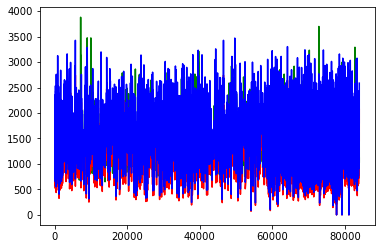

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

test_results = results.sort_values(by='trj_id')
plot(test_results['trj_id'], test_results['actual'], color='green')
plot(test_results['trj_id'], test_results['predicted'], color='red')
plot(test_results['trj_id'], test_results['test_predicted_manual'], color='blue')

In [53]:
weekend_normal = pd.read_csv('weekend_geohash_normal_6.csv')
weekend_normal = weekend_normal.groupby('node_trip').agg(['max','min']).reset_index()
weekend_normal.head()

node_trip trj_id        geohash_source         geohash_dest          \
                    max    min            max     min          max     min   
0  w21xjz-w21xjy  10452  10452         w21xjz  w21xjz       w21xjy  w21xjy   
1  w21xmb-w21xjz  10452  10452         w21xmb  w21xmb       w21xjz  w21xjz   
2  w21xmc-w21xmb  10452  10452         w21xmc  w21xmc       w21xmb  w21xmb   
3  w21xmf-w21xq1  10452  10452         w21xmf  w21xmf       w21xq1  w21xq1   
4  w21xmg-w21xmf  10452  10452         w21xmg  w21xmg       w21xmf  w21xmf   

      timestamp_source                            timestamp_dest  \
                   max                  min                  max   
0  2019-04-21 10:39:55  2019-04-21 10:39:55  2019-04-21 10:40:38   
1  2019-04-21 10:38:41  2019-04-21 10:38:41  2019-04-21 10:40:04   
2  2019-04-21 10:38:18  2019-04-21 10:38:18  2019-04-21 10:38:45   
3  2019-04-21 10:37:13  2019-04-21 10:37:13  2019-04-21 10:38:06   
4  2019-04-21 10:36:37  2019-04-21 10:36:37  2019-04-21 10:37:21   

                       time_taken       hour     day      
                   min        max   min  max min max min  
0  2019-04-21 10:40:38       43.0  43.0   10  10   6   6  
1  2019-04-21 10:40:04       83.0  83.0   10  10   6   6  
2  2019-04-21 10:38:45       27.0  27.0   10  10   6   6  
3  2019-04-21 10:38:06       53.0  53.0   10  10   6   6  
4  2019-04-21 10:37:21       44.0  44.0   10  10   6   6

In [54]:
weekend_normal.head(30)

node_trip trj_id        geohash_source         geohash_dest          \
                     max    min            max     min          max     min   
0   w21xjz-w21xjy  10452  10452         w21xjz  w21xjz       w21xjy  w21xjy   
1   w21xmb-w21xjz  10452  10452         w21xmb  w21xmb       w21xjz  w21xjz   
2   w21xmc-w21xmb  10452  10452         w21xmc  w21xmc       w21xmb  w21xmb   
3   w21xmf-w21xq1  10452  10452         w21xmf  w21xmf       w21xq1  w21xq1   
4   w21xmg-w21xmf  10452  10452         w21xmg  w21xmg       w21xmf  w21xmf   
5   w21xmu-w21xmg  10452  10452         w21xmu  w21xmu       w21xmg  w21xmg   
6   w21xq1-w21xmc  10452  10452         w21xq1  w21xq1       w21xmc  w21xmc   
7   w21xq4-w21xq1  10452  10452         w21xq4  w21xq4       w21xq1  w21xq1   
8   w21xqh-w21xmu  10452  10452         w21xqh  w21xqh       w21xmu  w21xmu   
9   w21xqj-w21xqh  10452  10452         w21xqj  w21xqj       w21xqh  w21xqh   
10  w21xqn-w21xqj  10452  10452         w21xqn  w21xqn       w21xqj  w21xqj   
11  w21xqn-w21xqp  18425  18425         w21xqn  w21xqn       w21xqp  w21xqp   
12  w21xqn-w21xqr  37378  37378         w21xqn  w21xqn       w21xqr  w21xqr   
13  w21xqp-w21xqn  72861  10452         w21xqp  w21xqp       w21xqn  w21xqn   
14  w21xqp-w21xqr  37378  37378         w21xqp  w21xqp       w21xqr  w21xqr   
15  w21xqp-w21xw0  18425  18425         w21xqp  w21xqp       w21xw0  w21xw0   
16  w21xqr-w21xqx  37378  37378         w21xqr  w21xqr       w21xqx  w21xqx   
17  w21xqr-w21xw2  37378  37378         w21xqr  w21xqr       w21xw2  w21xw2   
18  w21xqx-w21xqz  37378  37378         w21xqx  w21xqx       w21xqz  w21xqz   
19  w21xqx-w21xw8  72861   5768         w21xqx  w21xqx       w21xw8  w21xw8   
20  w21xqz-w21xqx  72861   5768         w21xqz  w21xqz       w21xqx  w21xqx   
21  w21xqz-w21xwb  37378  37378         w21xqz  w21xqz       w21xwb  w21xwb   
22  w21xw0-w21xqp  72861  10452         w21xw0  w21xw0       w21xqp  w21xqp   
23  w21xw0-w21xw1  18425  18425         w21xw0  w21xw0       w21xw1  w21xw1   
24  w21xw1-w21xw0  72861   5768         w21xw1  w21xw1       w21xw0  w21xw0   
25  w21xw1-w21xw3  30022  18425         w21xw1  w21xw1       w21xw3  w21xw3   
26  w21xw2-w21xqr  37378  37378         w21xw2  w21xw2       w21xqr  w21xqr   
27  w21xw3-w21xw1  72861   5768         w21xw3  w21xw3       w21xw1  w21xw1   
28  w21xw3-w21xw6  72861   5768         w21xw3  w21xw3       w21xw6  w21xw6   
29  w21xw6-w21xw3  72861   5768         w21xw6  w21xw6       w21xw3  w21xw3   

       timestamp_source                            timestamp_dest  \
                    max                  min                  max   
0   2019-04-21 10:39:55  2019-04-21 10:39:55  2019-04-21 10:40:38   
1   2019-04-21 10:38:41  2019-04-21 10:38:41  2019-04-21 10:40:04   
2   2019-04-21 10:38:18  2019-04-21 10:38:18  2019-04-21 10:38:45   
3   2019-04-21 10:37:13  2019-04-21 10:37:13  2019-04-21 10:38:06   
4   2019-04-21 10:36:37  2019-04-21 10:36:37  2019-04-21 10:37:21   
5   2019-04-21 10:36:21  2019-04-21 10:36:21  2019-04-21 10:36:47   
6   2019-04-21 10:38:06  2019-04-21 10:38:06  2019-04-21 10:38:24   
7   2019-04-21 10:37:47  2019-04-21 10:37:47  2019-04-21 10:38:15   
8   2019-04-21 10:35:42  2019-04-21 10:35:42  2019-04-21 10:36:28   
9   2019-04-21 10:35:07  2019-04-21 10:35:07  2019-04-21 10:35:52   
10  2019-04-21 10:34:26  2019-04-21 10:34:26  2019-04-21 10:35:14   
11  2019-04-21 09:07:47  2019-04-21 09:07:47  2019-04-21 09:10:00   
12  2019-04-20 08:48:10  2019-04-20 08:48:10  2019-04-20 08:48:51   
13  2019-04-21 10:33:08  2019-04-20 08:37:22  2019-04-21 10:34:39   
14  2019-04-20 08:48:46  2019-04-20 08:48:46  2019-04-20 08:48:55   
15  2019-04-21 09:09:50  2019-04-21 09:09:50  2019-04-21 09:10:31   
16  2019-04-20 08:50:08  2019-04-20 08:50:08  2019-04-20 08:51:31   
17  2019-04-20 08:48:51  2019-04-20 08:48:51  2019-04-20 08:49:49   
18  2019-04-20 08:54:59  2019-04-20 08:54:59  2019-04-20 08:55:22   
19  2019-04-21 18:31:50  2019-

In [149]:
weekend_normal = pd.read_csv('weekend_geohash_normal.csv')
weekend_normal.head()

,trj_id,geohash_source,geohash_dest,timestamp_source,timestamp_dest,time_taken,hour,day,node_trip
0,10011,w21xx8v,w21xx8y,2019-04-20 08:06:26,2019-04-20 08:06:27,1.0,8,5,w21xx8v-w21xx8y
1,10011,w21xx8y,w21xx8z,2019-04-20 08:06:27,2019-04-20 08:06:37,10.0,8,5,w21xx8y-w21xx8z
2,10011,w21xx8z,w21xx8x,2019-04-20 08:06:37,2019-04-20 08:06:45,8.0,8,5,w21xx8z-w21xx8x
3,10011,w21xx8x,w21xxbb,2019-04-20 08:06:45,2019-04-20 08:06:46,1.0,8,5,w21xx8x-w21xxbb
4,10011,w21xxbb,w21xxb8,2019-04-20 08:06:46,2019-04-20 08:06:47,1.0,8,5,w21xxbb-w21xxb8


In [ ]:
#nx.shortest_path_length(G,source='w21z6hb',target='w21zep1')
path = nx.dijkstra_path(weekday_normal_G,source='w21z7n9',target='w23b1fy', weight='weight')
total_weight = 0
for i in range(len(path) - 1):
    total_weight += weekday_normal_G[path[i]][path[i+1]]['weight']
print(total_weight)

In [148]:
mean_squared_error(results['actual'], results['test_predicted_manual'])

378070.5397379378

In [151]:
print(len(weekend_normal))
print(len(unique(weekend_normal['node_trip'])))

205091
17909
